# Project Report
Li Chang, [Udacity Machine Learning](www.udacity.com/course/ud120) Final Project

## Background
Enron Corporation, one of the largest American companies in history, bankruped after its share price plummeted from ~91 US dollars in 2000 to just pennies in late 2011. The concequences of Enron's bankrupcy was catastrophic: nearly 20,000 staff lost jobs, stock market crashed at the wake of the Enron scandal, and millions of investors lost their pension funds. Although Enron's fall is largely due to the misleading accounting practices and fabricated numbers, the root cause is largely because of its people - the negligence of the senior management and the misconduct of the traders on the floor. 

This project aims to examine Enron dataset, explore the relationship between various Enron's stakeholders, and produce a machine learning classifier to identify whether he or she is a person of interest(POI). A [POI](https://www.udacity.com/course/viewer#!/c-ud120/l-2291728537/m-2473678541) is defined as someone who got indicted, settled without admitting guilt or testified in exchange for immunity. 

##1. Dataset
###1.1 Data Exploration
This dataset has a total of 146 records, each containing 21 variables of which 14 are financial features, 6 are email features and 1 is labelling variable(POI). 

In [1]:
#Import packages
from feature_format import featureFormat, targetFeatureSplit
from tester import test_classifier, dump_classifier_and_data

import pickle
import numpy as np
import operator
import pprint as pp
import time
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
from scipy.stats import describe
from sklearn import preprocessing

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.learning_curve import learning_curve
from sklearn import cross_validation
from sklearn.cross_validation import StratifiedKFold
from __future__ import print_function

In [2]:
### Load the dictionary containing the dataset
data_dict = pickle.load(open("final_project_dataset.pkl", "r") )

### Provide basic information
records = len(data_dict)
print("Number of records: %i" % records)

number_keys = len(data_dict.values()[0].keys())
print("Number of variables: %i" % number_keys)

poi = 0
for person in data_dict.values(): 
    if person["poi"]:
        poi +=1
print("Number of POIs: %i" % poi)

### Print an example
print("An example:")
pp.pprint(data_dict.items()[0])

Number of records: 146
Number of variables: 21
Number of POIs: 18
An example:
('METTS MARK',
 {'bonus': 600000,
  'deferral_payments': 'NaN',
  'deferred_income': 'NaN',
  'director_fees': 'NaN',
  'email_address': 'mark.metts@enron.com',
  'exercised_stock_options': 'NaN',
  'expenses': 94299,
  'from_messages': 29,
  'from_poi_to_this_person': 38,
  'from_this_person_to_poi': 1,
  'loan_advances': 'NaN',
  'long_term_incentive': 'NaN',
  'other': 1740,
  'poi': False,
  'restricted_stock': 585062,
  'restricted_stock_deferred': 'NaN',
  'salary': 365788,
  'shared_receipt_with_poi': 702,
  'to_messages': 807,
  'total_payments': 1061827,
  'total_stock_value': 585062})


### 1.2 Outliers Investigation
After eye-balling these records, I decided to take the following actions: 
* Removed 'THE TRAVEL AGENCY IN THE PARK' - Even if this "agency" did receive a significant amount of payments from Enron, it's simply a third-party service provider, thereof, irrelevant for my investigation. 
* Removed 'Total' - Obviously, this record is meaningless because it's just an aggragtate of all the numbers. 
* Removed 'LOCKHART EUGENE E' - This record does not contain any value and was therefore removed. 

In [3]:
### Remove outliers
removed = ['THE TRAVEL AGENCY IN THE PARK', 'TOTAL', 'LOCKHART EUGENE E']
pp.pprint(data_dict['THE TRAVEL AGENCY IN THE PARK'])
pp.pprint(data_dict['TOTAL'])
pp.pprint(data_dict['LOCKHART EUGENE E'])

for name in removed:
    print("Removed: %s" %name)
    pp.pprint(data_dict[name])
    data_dict.pop(name)

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 362096,
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 362096,
 'total_stock_value': 'NaN'}
{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False,
 'restricted_stock': 130322299,
 'restricted_stock_de

##2. Optimize Feature Selection/Engineering
###2.1 Create new features
I created some ratio features, for example, by dividing bonus, fees, and stock options by salary or total stock values. I believe a person's compensation should be proportionate to his/her salary. Any absorbant high ratio is likely to redflag something fishy.
* Bonus as a share of salary: 'bonus'/'salary'
* Total stock vlaue as compared to salary: 'total_stock_value'/'salary'
* Long term incentive as compared to salary: 'long_term_incentive'/'salary'
* Expenses as a share of salary: 'expense'/'salary' An employee's expense should be proportionate to his salaries. 
* Exercised stock options as a share of total stock value: 'exercised_stock_options'/'total_stock_value'. When I was researching on Enron scandal, one thing jumping out is that some POIs had exercised their options before the market crash.
* deferral payment as a share of total payment: 'deferral_payments'/'total_payments'

I think the email exchange with POI as a share of this person's total email communication is a better indicator than the sheer volume, especially for those who joined the company at a relative late time but has a higher share of email exchanges with POIs. Though he/she might have relatively smaller number of emails, I believe this person's chance of being a POI would be higher than a person with relatively lower share of email exchange with other POIs.

* Emails from this person to POI as a share of total messages sent: 'from_this_person_to_poi'/'from_messages' 
* Emails from POI to this person as a share of total messages received: 'from_poi_to_this person'/'to_messages'

In [4]:
### Create new feature(s)
def compute_share(a,b,output):
    if person[a] == 'NaN' or person[b]=='NaN':
        person[output] = 'NaN'
    else:
        person[output]= round(float(person[a])/float(person[b]),4)

for person in data_dict.values():
    compute_share('bonus', 'salary', 'bonus_vs_salary')
    compute_share('total_stock_value','salary', 'stock_vs_salary')
    compute_share('long_term_incentive', 'salary', 'incentive_vs_salary')
    compute_share('expenses', 'salary', 'expenses_vs_salary')
    compute_share('exercised_stock_options', 'total_stock_value', 'exercised_share_stock')
    compute_share('deferral_payments', 'total_payments', 'deferral_share_total_payment')
    compute_share('from_poi_to_this_person', 'to_messages', 'received_from_poi_share')
    compute_share('from_this_person_to_poi', 'from_messages', 'sent_to_poi_share')

### Prepare for feature selection
features_list_all = ["poi", 
                     #original financial features
                     'salary', 
                     'bonus', 
                     'restricted_stock_deferred', 
                     'deferred_income', 
                     'total_stock_value', 
                     'expenses', 
                     'exercised_stock_options', 
                     'long_term_incentive', 
                     'restricted_stock', 
                     'director_fees', 
                     #new finanical features 
                     'bonus_vs_salary',
                     'stock_vs_salary',
                     'incentive_vs_salary',
                     'expenses_vs_salary',
                     'exercised_share_stock',
                     'deferral_share_total_payment',
                     #original email features
                     'from_poi_to_this_person', 
                     'from_this_person_to_poi', 
                     'shared_receipt_with_poi',
                     #new email features
                     'received_from_poi_share',
                     'sent_to_poi_share']

###2.2 Select features
####Exploratory data analysis with visualizations
Visualization is a great way to get a glimpse of what's happening. I plotted the distributions of selected variables by POI groups. Some variables like "director_fee",  "restricted_stock_preferred" can be removed from this point as either POI or non-POI group is missing these information and therefore not meaningful. Below is what I observed:

Moderate difference between POI and non-POI groups:
* "salary"
* "bonus"
* "expenses"
* "total_stock_value"
* "exercised_stock_options"
* "long_term_incentive"
* "restricted stock"
* "bonus_vs_salary"
* "shared_receipt_with_poi"
* "received_from_poi_share"
* "sent_to_poi_share"

Slight difference:
* "deferred_income"
* "exercised_share_stock"
* "deferral_share_payment"
* "from_poi_to_this_person"
* "from_this_person_to_poi"

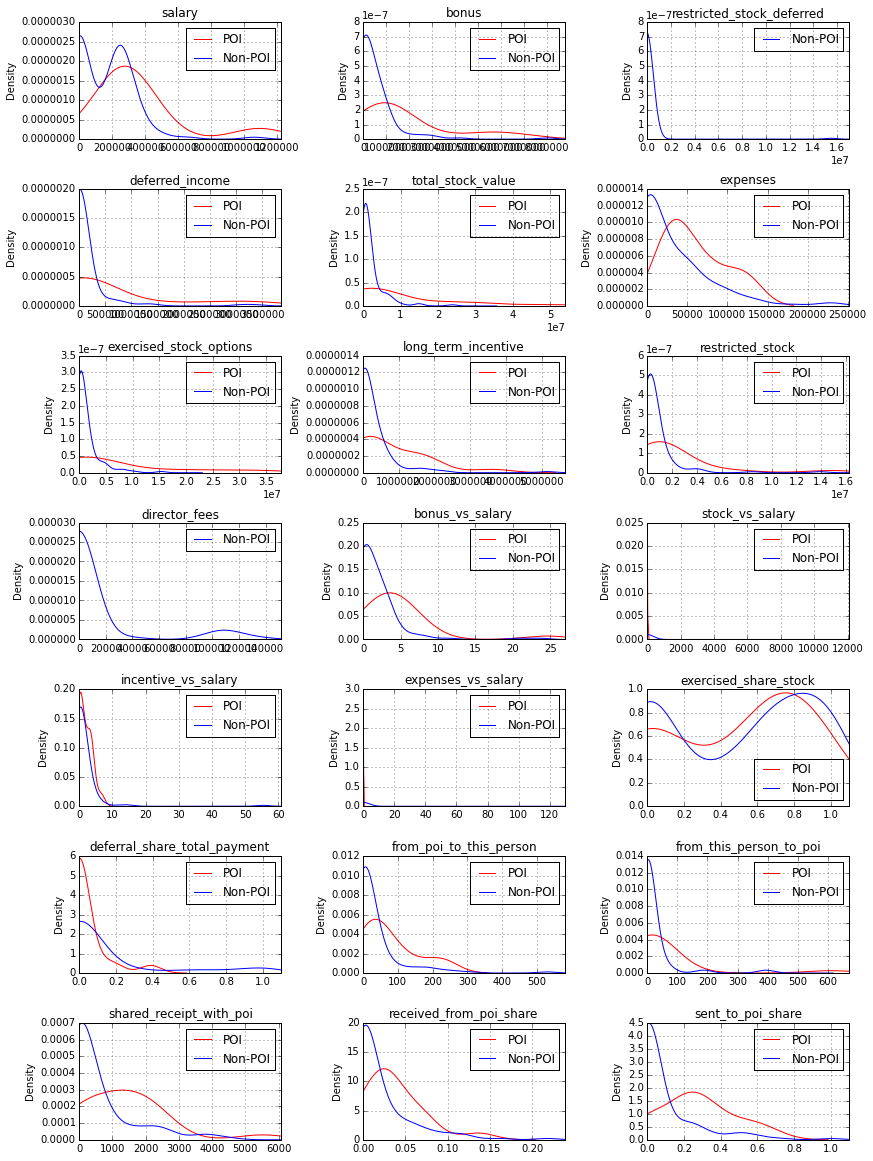

In [5]:
###Plot exploratory graphs
###Convert dictionary to dataframe
df = pd.DataFrame.from_dict(data_dict, orient='columns')
df = df.transpose()
###treat NaN as 0
df = df.replace('NaN',0)
### Deferred income is stored as negative values
df['deferred_income'] = [abs(v) for v in df['deferred_income']]
poi = df[(df.poi)]
non_poi = df[(df.poi == False)]

plt.figure(figsize=(len(features_list_all)/1.8, len(features_list_all)/1.2))
for i in range(1, len(features_list_all)):
    feature = features_list_all[i]
    #convert to float
    df[feature] = df[feature].astype(float)
    #Set up canvas with 3 graphs per row
    ax = plt.subplot2grid((len(features_list_all)/3+1,3), ((i-1)/3, (i-1)%3))
    #plot non-zero series 
    if max(poi[feature]) != 0:
        poi[feature].plot(kind='kde', label = 'POI', legend = True, color = 'red')
    if max(non_poi[feature]) != 0 :
        non_poi[feature].plot(kind='kde', label = 'Non-POI', legend = True, color = 'blue')
    ax.set_title("%s" % feature)
    ax.set_xlim((0, max(df[feature])*1.1))
plt.tight_layout()
plt.show()

In [6]:
###Remove irrelevant features
features_list_all.remove('director_fees')
features_list_all.remove('restricted_stock_deferred')

####Tree-based feature selection
Another way to select features relying on machine learning models is [tree-based selection](###http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#example-ensemble-plot-forest-importances-py
). Feature importance is plotted below. The most important feature is 'expense' and the importance drops significantly after that. For the top important features, the newly computed ratios appear to have lower importance than the original ones. 

Based off results from both visualization and tree-based selection, I experimented with different combinations of top features by feature ranking and chose the top four important features including 'expenses','total_stock_value', 'bonus', 'deferred_income' as my final features.

Feature imporances
[ 0.02  0.06  0.06  0.1   0.2   0.06  0.02  0.04  0.02  0.08  0.04  0.08
  0.06  0.    0.02  0.02  0.04  0.02  0.06]
Feature ranking:
1. feature 4, expenses: (0.200000)
2. feature 3, total_stock_value: (0.100000)
3. feature 9, stock_vs_salary: (0.080000)
4. feature 11, expenses_vs_salary: (0.080000)
5. feature 1, bonus: (0.060000)
6. feature 2, deferred_income: (0.060000)
7. feature 5, exercised_stock_options: (0.060000)
8. feature 18, sent_to_poi_share: (0.060000)
9. feature 12, exercised_share_stock: (0.060000)
10. feature 10, incentive_vs_salary: (0.040000)
11. feature 7, restricted_stock: (0.040000)
12. feature 16, shared_receipt_with_poi: (0.040000)
13. feature 17, received_from_poi_share: (0.020000)
14. feature 8, bonus_vs_salary: (0.020000)
15. feature 6, long_term_incentive: (0.020000)
16. feature 14, from_poi_to_this_person: (0.020000)
17. feature 15, from_this_person_to_poi: (0.020000)
18. feature 0, salary: (0.020000)
19. feature 13, deferral_share_total_p

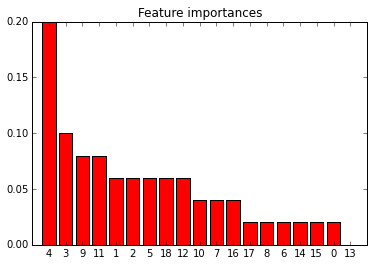

In [7]:
###Split features and labels
data_all = featureFormat(data_dict, features_list_all) 
labels_all, features_all = targetFeatureSplit(data_all)

### Compute the feature importances
clf_f = AdaBoostClassifier(random_state=202)
clf_f.fit(features_all, labels_all)
importances = clf_f.feature_importances_
print("Feature imporances")
print(importances)

indices = np.argsort(importances)[::-1]
number_features = len(features_list_all)-1

#### Print the feature ranking
print("Feature ranking:")
for f in range(number_features):
    indice = indices[f]
    print("%d. feature %d, %s: (%f)" % (f + 1, indice, features_list_all[1:][indice], importances[indice]))

#### Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(number_features), importances[indices],
        color="r",
        align="center")
plt.xticks(range(number_features), indices)
plt.xlim([-1, number_features])
plt.show()

###2.3 Feature scaling
For the final features, I used [min-max](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) to scale features as it's required for some classifiers tried below, e.g. Logistics Regression and K-Neighbours. For the tree-based classifiers, feature scaling doesn't matter and nor will it alter results even if I use the scaled features. 

In [8]:
### final features for modelling
features_list =['poi',
                'expenses', 
                'total_stock_value', 
                'bonus', 
                'deferred_income', 
                 ]
###Scale features
min_max_scaler = preprocessing.MinMaxScaler()
for feature in features_list[1:]:
    df[feature] = min_max_scaler.fit_transform(df[feature].astype(float))
my_dataset = df.T.to_dict('dict')
### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
### Convert labels to integer
labels = map(int, labels)

##3. Pick and Tune an Algorithm
###3.1 Pick an algorithm
For the first taste, I tried Logistics Regression, Naives Bayes, Support Vector Machine, Decision Trees, Random Forest, and Adaboost. I used two ways to pick my final algorithm, validation metrics and learning curve. 

####Validation Metrics
Adapting the <code>tester.py</code> codes, I used precision score and recall score to select the model. These two metrics measures the percentage of true positive identified from a certain population. The higher the scores are, the better the model is. From the metrics below, I will be interested to proceed with Naives Bayes, Decision Trees, and AdaBoost, which have precision and recall scores above 0.3 to start with. Given our small sample size, <code>tester.py</code> used [StratifiedShuffleSplit](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html) for cross-valdiate the models. It randomly splits dataset to train and test sets on a 9-1 ratio (default setting  test_size=0.1) while perserving the proportion of POI and non-POI samples. It returns averaged scores over 1000 iterations for us to choose from. 

In [9]:
### Create classifiers
lr = LogisticRegression()
gnb = GaussianNB()
svc = LinearSVC()
kn = KNeighborsClassifier()
dt =  DecisionTreeClassifier()
rfc = RandomForestClassifier()
adb = AdaBoostClassifier()

models = [(lr, 'Logistic'),
          (gnb, 'Naive Bayes'),
          (svc, 'Support Vector Classification'),
          (kn, 'K-Neighbors'),
          (dt, 'Decison Tree'),
          (rfc, 'Random Forest'),
          (adb, 'AdaBoost')]

for clf, name in models :
    test_classifier(clf, my_dataset, features_list, folds = 1000)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)
	Accuracy: 0.86967	Precision: 0.92453	Recall: 0.02450	F1: 0.04774	F2: 0.03042
	Total predictions: 15000	True positives:   49	False positives:    4	False negatives: 1951	True negatives: 12996

GaussianNB()
	Accuracy: 0.86320	Precision: 0.48177	Recall: 0.34350	F1: 0.40105	F2: 0.36442
	Total predictions: 15000	True positives:  687	False positives:  739	False negatives: 1313	True negatives: 12261

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
	Accuracy: 0.86440	Precision: 0.46953	Recall: 0.13100	F1: 0.20485	F2: 0.15307
	Total predictions: 15000	True positives:  262	False positives:  296	Fals

####Learning Curve
Learning curves help [find out hom much the model would benefit from adding more sample](http://scikit-learn.org/stable/modules/learning_curve.html).The training score and validation score of Naives Bayes converged, indicating that the model would not gain much by increasing number of training data. For AdaBoost on the other hand, the training scores didn't get worse; the cross-validation score curve improved with the increase of samples while it declines slightly with Decision Trees. Therefore, I decided to use Adaboost as my final classifer. 


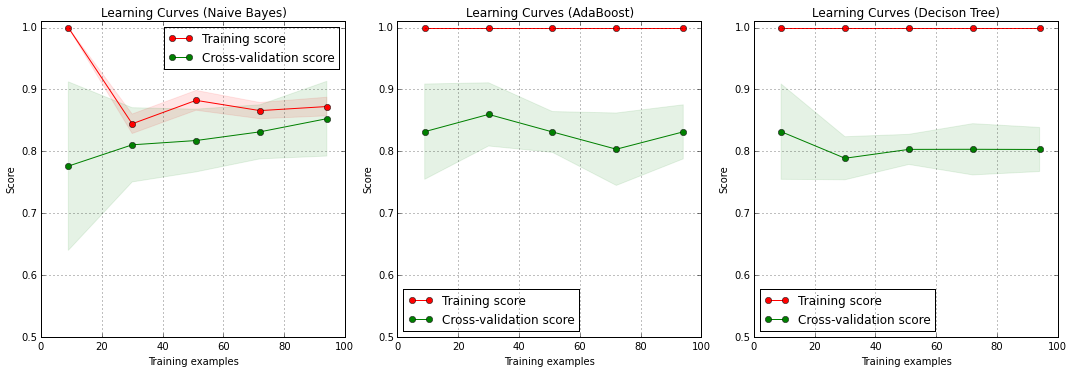

In [10]:
###Shortlist models
models_s = [(gnb, 'Naive Bayes'),
            (adb, "AdaBoost"),
            (dt, 'Decison Tree'),]
###Plot learning curves. 
plt.figure(figsize=(len(models_s)*5,len(models_s)*1.75))
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.tight_layout()
    return plt

cv = StratifiedKFold(labels, n_folds=3)

j = 0
for clf, name in models_s:
    title = "Learning Curves (%s)" %name
    ax = plt.subplot2grid((1,len(models_s)), (0, j))
    plot_learning_curve(clf, title, features, labels, (0.5, 1.01), cv = cv)
    j +=1

###3.2 Tune Parameters
To make sure the results are consistent between <code>tester.py</code> and this section, I used <code>tester.py</code> to tune up [n_estimator and learning rate for Adaboost](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) and choose the one with the best precision score and recall score. Parameter-tuning a necessary step to optimize models. For n_estimator, I tested different values between  10 and 1000; For learning rate, I tested between 0.01 to 2. The results are below. The best parameters appear to be n_estimators = 50 and learning_rate = 1.0 (default setting), which gives 0.52 for precision score and 0.37 for recall score.

In [11]:
###Tune parameters
n_estimators = [10, 50, 100, 250, 1000]
learning_rate = [0.01, 0.1, 1.0, 1.5, 2]

### Iterate through all parameters
for i in range(len(n_estimators)):
    for j in range(len(learning_rate)):
        clf = AdaBoostClassifier(n_estimators = n_estimators[i], learning_rate = learning_rate[j])
        test_classifier(clf, my_dataset, features_list, folds = 1000)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.01, n_estimators=10, random_state=None)
	Accuracy: 0.84180	Precision: 0.13786	Recall: 0.03550	F1: 0.05646	F2: 0.04169
	Total predictions: 15000	True positives:   71	False positives:  444	False negatives: 1929	True negatives: 12556

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=10, random_state=None)
	Accuracy: 0.85787	Precision: 0.24219	Recall: 0.03100	F1: 0.05496	F2: 0.03755
	Total predictions: 15000	True positives:   62	False positives:  194	False negatives: 1938	True negatives: 12806

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=10, random_state=None)
	Accuracy: 0.86920	Precision: 0.51570	Recall: 0.31200	F1: 0.38879	F2: 0.33876
	Total predictions: 15000	True positives:  624	False positives:  586	False negatives: 1376	True negatives: 12414

AdaBoostClassifier(algorithm='SAMME.R', base_

###3.3 Validation 
One common mistake of building a model is to overfit the existing data. In simple words, the machine is trying so much to mimick the pattern of a certain form of dataset that it misses the big, true picture. Therefore, we need to split data into a development(training) set and an evaluation(testing) and compute the performance metrics for selecting the best parameters. AdaBoost with 50 n_estimators and 1.0 learnings rate appear to be my best model. The cross-validation results shown, again, below: 

In [12]:
clf = AdaBoostClassifier(n_estimators = 50, learning_rate = 1.0)
test_classifier(clf, my_dataset, features_list, folds = 1000)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
	Accuracy: 0.87060	Precision: 0.52103	Recall: 0.36550	F1: 0.42962	F2: 0.38871
	Total predictions: 15000	True positives:  731	False positives:  672	False negatives: 1269	True negatives: 12328



###3.4 Evaluation Metrics

One commonly-used metric is accuracy score, which measures the proportion of true results (both positive and negative) among the entire sample. For this project, the classifer's ability to identify POI is more important. Therefore, the evaluation metricss I used throughout this project are in favor of precision score and recall score.
####Precision
The presision score measures the classifier's ability [not to label negative sample as positve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html). It's easier to grasp the idea that the better the classifer predicts the true POIs, the better the score it would be. However, if the classifer mis-predicts many non-POIs as POIs, for example, to redflag 'Metts Mark' as a suspicious POI even though he is not, it would lower the precision score. If the strategy is to redflag as many potential POIs as possible, you may have higher tolerance of the classifer mislabelling non-POIs (therefore accept a lower precision score), just to be risk-averse. My classifer achieved 0.52 average precision scores for 1000 cross-validated folds of dataset. It means that of the 2 likely POIs that my model predicts, 1 are truly POI. 

####Recall
The recall score measures the classifier's ability to [identify all the positive samples](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html). If the classifer fails to label, say, 'SHELBY REX' as a POI, it will potentially lower the recall score. My model gets 0.37 on average for the recall socre, which is substantially lower than precision and indicates room for improvement. Nevertheless, with a recall score of 0.37, it means that for every 100 true POIs, 37 will be flagged as POI. 

In [13]:
### Dump the classifier, dataset, and features_list 
dump_classifier_and_data(clf, my_dataset, features_list)

##Conclusions & Reflections
This project explored Enron dataset and developed an AdaBoost model for identifying and predicting POIs. Using 1000-fold cross-validations, this model returns a precision score of 0.52 and a recall score of 0.37. The model may be further improved by adding more information. It's challenging to work with a dataset of ~140 records and 18 POIs. Actually, the <code>poi_names.txt</code> contains 35 names from [this post](http://usatoday30.usatoday.com/money/industries/energy/2005-12-28-enron-participants_x.htm). However, many are missing financial information from the <code>enron61702insiderpay.pdf</code>. It will be great if we can ferret out information for them, which will nearly double the number of POIs.

Also, the email features look interesting and reveal moderate difference between POI and non-POI groups but didn't really help the model at the end. One area of improvement is to construct additional email features, for example, frequency of key words from email messages. 
